In [1]:
import numpy as np
import matplotlib.pyplot as plt

from timescales.sim import sim_spikes_synaptic, sim_branching
from neurodsp.sim import sim_action_potential, sim_oscillation

from timescales.fit import ACF, fit_psd, convert_knee_val

from neurodsp.spectral import compute_spectrum
from neurodsp.filt import filter_signal
from neurodsp.timefrequency import amp_by_time
from neurodsp.utils.norm import normalize_sig

### Low-Pass (LFP) vs High-Pass (Spikes) Timescale Estimation

This notebooks compares timescale estimation from spike trains (i.e. from the high-pass of a signal) and from the LFP (i.e. the low-pass of a signal). The goal of either method is to determine the lower-frequency structure of how spikes are distributed across time. In the simulation method, this is equivalent to determining the exponentially decaying probability distribution, which spikes are sampled from. Binning spike trains is one method of estimating these distributions across time. However, the low-pass contains the same information with the benefit of not requiring discretization from time binning or from the need to tune the bin size.

In [2]:
# Simulate spike times
np.random.seed(0)
n_seconds = 100
fs = 12000
n_neurons = 1
tau = convert_knee_val(10)

probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=n_neurons, return_sum=False)
_probs = probs * .5
spikes = (_probs > np.random.rand(*_probs.shape))

times = np.arange(0, n_seconds, 1/fs)

# Simulate spike waveform
n_samples = 25
centers = [.3, .5, .7]
stds = [.08, .1, .08]
alphas = [.1, 0, .1]
heights = [.2, -.8, .3]
spike_wave = sim_action_potential(1, n_samples, centers, stds, alphas, heights)

# Convolve spike waveform
spike_ts = np.convolve(spikes, spike_wave, mode='same')

### Simulation

The spikes times (first plot) are convolved with the simulated spike waveform (second plot) to produce a simulated high-pass timeseries that contains spikes.

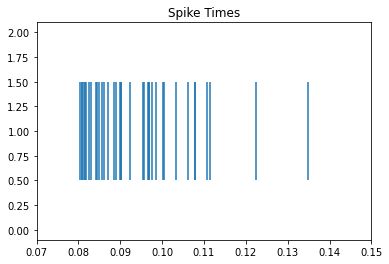

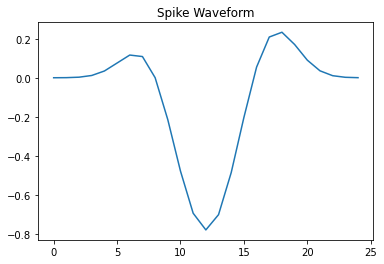

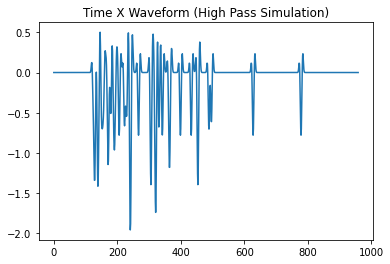

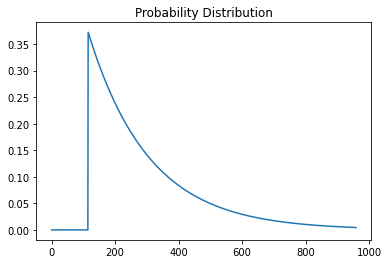

In [3]:
plt.figure(0)
t_bounds = [.07, .15]
plt.title('Spike Times')
plt.eventplot(times[spikes])
plt.xlim(*t_bounds)

plt.figure(1)
plt.title('Spike Waveform')
plt.plot(spike_wave);

plt.figure(2)
plt.title('Time X Waveform (High Pass Simulation)')
plt.plot(spike_ts[int(fs * t_bounds[0]):int(fs * t_bounds[1])]);

plt.figure(3)
plt.title('Probability Distribution')
plt.plot(probs[int(fs * t_bounds[0]):int(fs * t_bounds[1])])

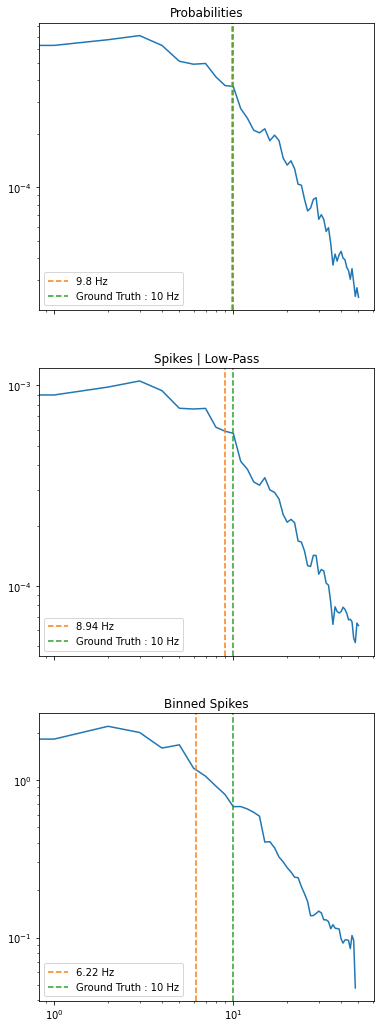

In [4]:
# Filter
spike_ts_lp = filter_signal(spike_ts, fs, 'lowpass', 100, remove_edges=False)
spike_ts_hp = filter_signal(spike_ts, fs, 'highpass', 100, remove_edges=False)

# Bin spikes
spike_times = np.zeros(len(spike_ts), dtype=bool)
spike_times[spikes] = 1

win_size = .008
binned_spikes = spike_times.reshape(-1, int(win_size * fs)).sum(axis=1)

# Compute spectra
f_range = (0, 50)
f0, p0 = compute_spectrum(probs, fs, f_range=f_range)
f1, p1 = compute_spectrum(spike_ts_lp, fs, f_range=f_range)
f2, p2 = compute_spectrum(binned_spikes, fs * win_size, f_range=f_range)

# Compute knees
fooof_init = {'max_n_peaks': 0}
fm0, kf0, kt0 = fit_psd(f0, p0, f_range, fooof_init=fooof_init, knee_bounds=(.1, 50))
fm1, kf1, kt1 = fit_psd(f1, p1, f_range, fooof_init=fooof_init, knee_bounds=(.1, 50))
fm2, kf2, kt2 = fit_psd(f2, p2, f_range, fooof_init=fooof_init, knee_bounds=(.1, 50))

# Plot
fig, axes = plt.subplots(figsize=(6, 18), nrows=3, sharex=True)

axes[0].loglog(f0, p0)
axes[1].loglog(f1, p1)
axes[2].loglog(f2, p2)

axes[0].set_title('Probabilities')
axes[1].set_title('Spikes | Low-Pass')
axes[2].set_title('Binned Spikes')

axes[0].axvline(kf0, color='C1', ls='--', label=str(kf0.round(2)) + ' Hz')
axes[1].axvline(kf1, color='C1', ls='--', label=str(kf1.round(2)) + ' Hz')
axes[2].axvline(kf2, color='C1', ls='--', label=str(kf2.round(2)) + ' Hz')

axes[0].axvline(10, color='C2', ls='--', label='Ground Truth : 10 Hz')
axes[1].axvline(10, color='C2', ls='--', label='Ground Truth : 10 Hz')
axes[2].axvline(10, color='C2', ls='--', label='Ground Truth : 10 Hz')

axes[0].legend()
axes[1].legend()
axes[2].legend();

Below shows that the low-pass (inverse, since spikes are negatively deflecting) of the signal is an approximation of the simulated probabilitiy distribution itself. This approximation is more accurate than using discretization, or binned spikes (bottom).  

(0.0, 1000.0)

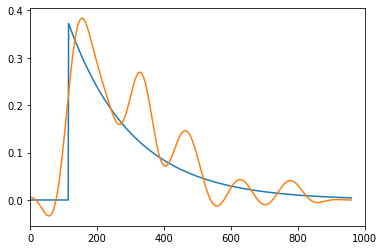

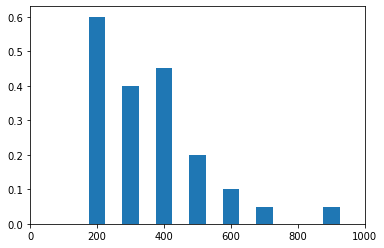

In [5]:
plt.figure(0)
plt.plot(probs[int(fs * t_bounds[0]):int(fs * t_bounds[1])])
plt.plot(-spike_ts_lp[int(fs * t_bounds[0]):int(fs * t_bounds[1])])
plt.xlim(0, 1000)

plt.figure(1)
plt.bar(np.arange(1, 11)*100, spikes[int(fs * t_bounds[0]):int(fs * t_bounds[1])].reshape(10, -1).sum(axis=1)/20,
        width=50);
plt.xlim(0, 1000)

### ACF

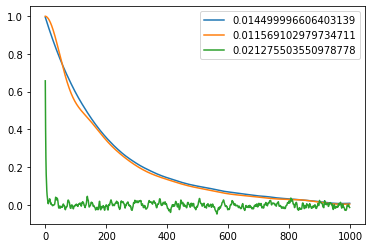

In [6]:
# Fit
acf_probs = ACF()
acf_probs.compute_acf(probs, fs, nlags=1000)
acf_probs.fit_cos()

acf_lp = ACF()
acf_lp.compute_acf(spike_ts_lp, fs, nlags=1000)
acf_lp.fit_cos()

acf_binned = ACF()
acf_binned.compute_acf(binned_spikes, fs * win_size, nlags=1000)
acf_binned.fit_cos()

# Plot
plt.plot(acf_probs.corrs, label=f'{acf_probs.params[0]}')
plt.plot(acf_lp.corrs, label=f'{acf_lp.params[0]}')
plt.plot(acf_binned.corrs, label=f'{acf_binned.params[0]}')
plt.legend();

### LFP and Spikes: Different Timescales 

What if the LFP contains one timescale (20hz) and the spike train contains a different timescale (10hz)? Below explores ways to separate the two components using filters and analytic amplitude.

The idea is that the high-pass analytic amplitude goes to zero outside of spikes, while the low-pass amplitude exists across spikes and LFP. Multipyling the two togther should result in zero amplitude where spikes do not exists, recreating the original probability array.

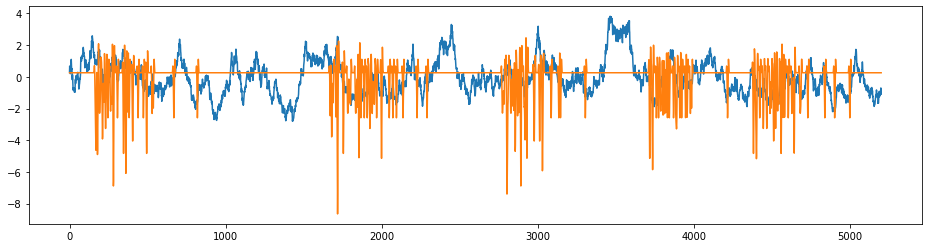

In [7]:
# Simulate
np.random.seed(0)

tau_branch = convert_knee_val(30)

# Time
sig_spike = normalize_sig(spike_ts, mean=0, variance=1)

sig_lfp = sim_branching(n_seconds, fs, tau_branch, 10)
sig_lfp = normalize_sig(sig_lfp, mean=0, variance=1)

sig_comb = (sig_spike/2) + (sig_lfp/2)

# Plot
inds = np.arange(800, 6000)

plt.figure(figsize=(16, 4))
plt.plot(sig_lfp[inds], label='LFP')
plt.plot(sig_spike[inds], label='Spikes')

Spikes:  9.335478270484558
LFP:  23.811337256592438
Comb:  17.782943913980297


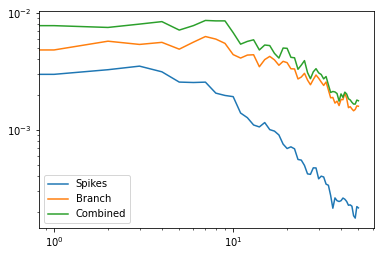

In [8]:
# Compute spectra
freqs_spikes, powers_spikes = compute_spectrum((sig_spike/2), fs, f_range=(0, 50))
freqs_lfp, powers_lfp = compute_spectrum((sig_lfp/2), fs, f_range=(0, 50))
freqs_comb, powers_comb = compute_spectrum(sig_comb, fs, f_range=(0, 50))

# Fit
fm_spikes, kf_spikes, kt_spikes = fit_psd(freqs_spikes, powers_spikes, (0, 50))

fm_lfp, kf_lfp, kt_lfp = fit_psd(freqs_lfp, powers_lfp, (0, 50))

fm_comb, kf_comb, kt_comb = fit_psd(freqs_comb, powers_comb, (0, 50))

print('Spikes: ', kf_spikes)
print('LFP: ', kf_lfp)
print('Comb: ', kf_comb)

# Plot
plt.loglog(freqs_spikes, powers_spikes, label='Spikes')
plt.loglog(freqs_lfp, powers_lfp, label='Branch')
plt.loglog(freqs_comb, powers_comb, label='Combined')
plt.legend();

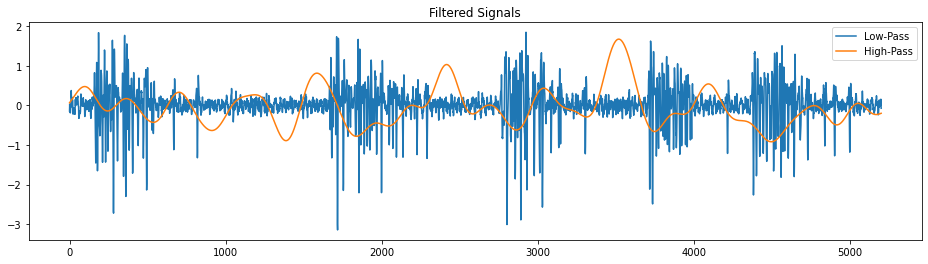

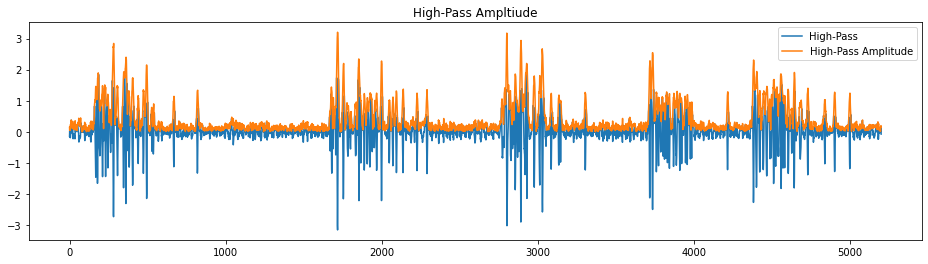

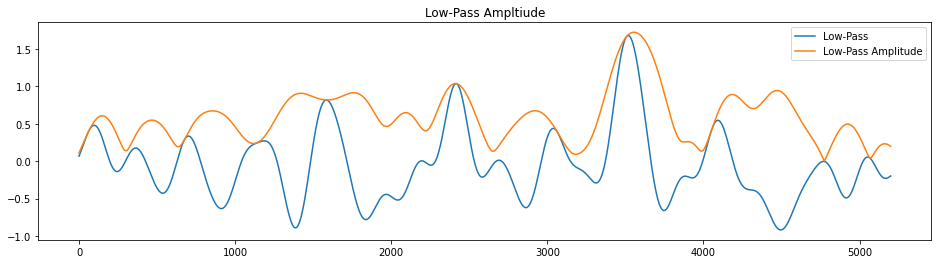

In [9]:
# Analytic Amplitude
sig_comb_hp = filter_signal(sig_comb, fs, 'highpass', 300, remove_edges=False)
sig_comb_lp = filter_signal(sig_comb, fs, 'lowpass',  50, remove_edges=False)

amp_hp = amp_by_time(sig_comb_hp, fs, remove_edges=False)
amp_lp = amp_by_time(sig_comb_lp, fs, remove_edges=False)

plt.figure(0, figsize=(16, 4))
plt.title('Filtered Signals')
plt.plot(sig_comb_hp[inds], label='Low-Pass')
plt.plot(sig_comb_lp[inds], label='High-Pass')
plt.legend()

plt.figure(1, figsize=(16, 4))
plt.title('High-Pass Ampltiude')
plt.plot(sig_comb_hp[inds], label='High-Pass')
plt.plot(amp_hp[inds], label='High-Pass Amplitude')
plt.legend()

plt.figure(2, figsize=(16, 4))
plt.title('Low-Pass Ampltiude')
plt.plot(sig_comb_lp[inds], label='Low-Pass')
plt.plot(amp_lp[inds], label='Low-Pass Amplitude')
plt.legend();

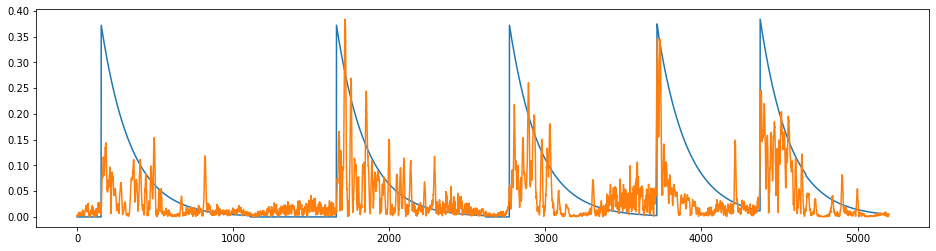

In [11]:
# Compute estimated probabiltities
probs_est = amp_hp * amp_lp

plt.figure(1, figsize=(16, 4))
plt.plot(probs[inds])
plt.plot(probs_est[inds] / np.max(probs_est[inds]) * np.max(probs[inds]))

10.943417818838155

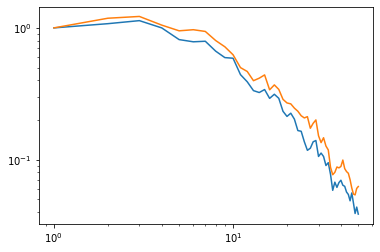

In [14]:
# Multiply low-pass amplitude and high-pass amplitude
probs_est = amp_hp * amp_lp
freqs_est, powers_est = compute_spectrum(probs_est, fs, f_range=(1, 50))
freqs_actual, powers_actual = compute_spectrum(probs, fs, f_range=(1, 50))

# Plot results
plt.loglog(freqs_actual, powers_actual/powers_actual[0])
plt.loglog(freqs_est, powers_est/powers_est[0])

fm_est, kf_est, kt_est = fit_psd(freqs_est, powers_est, (0, 50))

kf_est